In [1]:
import os
import glob
import shutil
from pathlib import Path
import tensorflow as tf
import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from skimage import transform
from PIL import Image 
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
from io import BytesIO
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')
%matplotlib inline

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Introduction

In this project we will try to resolve gender recognition task using ML and Deep Learning models. 

Dataset: https://www.kaggle.com/datasets/maciejgronczynski/biggest-genderface-recognition-dataset

This dataset contains approximately 27k images of faces divided by gender. We will train models on two preprocessed datasets. Both of them will have images rescaled to 100x100 size, converted to greyscale and normalized. In addition to that the second dataset will be augumented with operations such like flipping, rotating and changing brightness of the image.
We want to check if the augumentation of images impact training of the model and its results.

# Data exploration and preprocessing

In [3]:
data_dir = os.walk("faces")

#checking if there are some invalid file extensions in dataset
SplitTypes = []
for walk_output in data_dir:
    for file_name in walk_output[-1]:
        SplitTypes.append(file_name.split(".")[-1])

print(set(SplitTypes)) #printing unique values

{'jpg'}


In [4]:
#dataset contains only jpg files
#creating dataset with information about sizes, ratios and classes of images

files = glob.glob("faces\\**\*.jpg")
data_info = dict()
for idx, file in enumerate(files):
    with Image.open(file) as img:
        filename = os.path.basename(file)
        width, heigth = img.size
        data_info[idx] = {'filename': filename, 'width': width, 'height': heigth,
                          'dim': img.size, 'aspect_ratio': width/heigth, 'img_class': filename[0]}

data_info = pd.DataFrame.from_dict(data_info).T
data_info.head()

,filename,width,height,dim,aspect_ratio,img_class
0,man_10005.jpg,250,250,"(250, 250)",1.0,m
1,man_10006.jpg,250,250,"(250, 250)",1.0,m
2,man_10007.jpg,250,250,"(250, 250)",1.0,m
3,man_10008.jpg,250,250,"(250, 250)",1.0,m
4,man_10009.jpg,250,250,"(250, 250)",1.0,m


In [5]:
data_info.dim.value_counts() 

(250, 250)    13226
(100, 100)    11627
(113, 147)        4
(67, 86)          4
(80, 110)         3
              ...  
(349, 487)        1
(61, 91)          1
(320, 453)        1
(224, 303)        1
(144, 173)        1
Name: dim, Length: 2125, dtype: int64

In [6]:
#there are a lot of unique sizes so lets group pictures in three classes:
#big- images equal and bigger than 250x250
#medium- images between 250x250 and 100x100 (and equal to 100x100)
#small- images smaller than 100x100

def func(row):
    if row['width'] >=250 and row['height'] >=250:
        val = 'Big'
    elif row['width'] <100 and row['height'] <100:
        val = 'Small'
    else:
        val = 'Medium'
    return val

data_info['img_size'] = data_info.apply(func, axis = 1)

#grouping images by their aspect ratio
data_info['ratio'] = np.where(data_info['aspect_ratio'] != 1, 'Not square', 'Square')

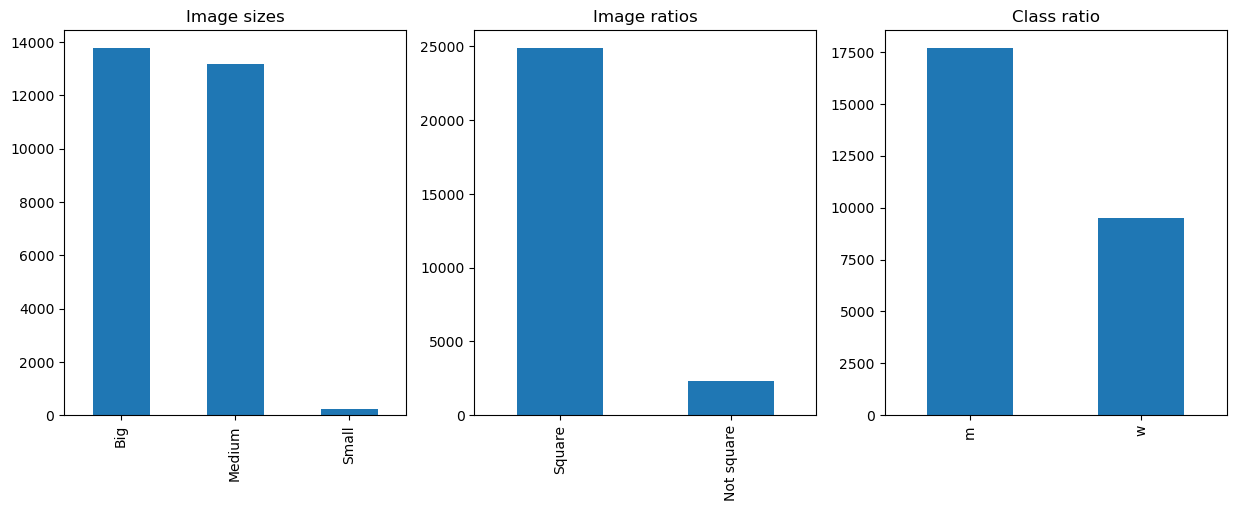

In [7]:
plt.rcParams["figure.figsize"] = (15,5)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
data_info.img_size.value_counts().plot(kind='bar',ax = ax1, title = 'Image sizes')
data_info.ratio.value_counts().plot(kind='bar',ax= ax2, title = "Image ratios")
data_info.img_class.value_counts().plot(kind='bar', ax = ax3, title = 'Class ratio')
plt.show()

In [8]:
#removing images smaller than 100x100

#list of images to remove
removeidx = np.where(data_info["img_size"]=="Small")[0].tolist()
remove = [data_info['filename'][idx] for idx in removeidx]

#new folder
data_dir = "faces"
destination_dir = "faces_cleaned"
isExist = os.path.exists(destination_dir)
if not isExist:
    shutil.copytree(data_dir, destination_dir)
    
data_dir = "faces_cleaned"

#removing images in new folder
files = glob.glob("faces_cleaned\\**\*.jpg")
for f in files:
    if os.path.basename(f) in remove:
        if isExist:
            os.remove(f)

### Dataset 1

In [9]:
batch_size = 64
image_size = (100, 100) #resizing images to 100x100

# 80/10/10 train/validation/test split, converting to grayscale and preserving aspect ratio
train_data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, 
                                                         subset="training", seed=123, image_size=image_size, 
                                                         color_mode = "grayscale",batch_size = batch_size,
                                                         crop_to_aspect_ratio=True)

test_val_data = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, 
                                                         subset="validation", seed=123, image_size=image_size, 
                                                         color_mode = "grayscale", batch_size=None, 
                                                         crop_to_aspect_ratio=True)

test_data, val_data = tf.keras.utils.split_dataset(
                      test_val_data, left_size=0.5, shuffle=True)

val_data = val_data.batch(batch_size = batch_size)
test_data = test_data.batch(batch_size = batch_size)

class_names = train_data.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_data).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_data).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data).numpy())

Found 26941 files belonging to 2 classes.
Using 21553 files for training.
Found 26941 files belonging to 2 classes.
Using 5388 files for validation.
Number of training batches: 337
Number of validation batches: 43
Number of test batches: 43


In [10]:
#checking class distribution in train set
count = np.zeros(2, dtype=np.int32)
for _, labels in train_data:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
n = count[0]+count[1]
print("Class distribution in train set:\n man:",round(count[0]/n,2),"woman:",round(count[1]/n,2))


#dataset is highly imbalanced
#performing resampling to balance out classes in train set
def class_func(features, label):
    return label

train_data_balanced = train_data.unbatch().rejection_resample(
                      class_func, target_dist=[0.5, 0.5])
train_data_balanced = train_data_balanced.batch(batch_size)
train_data_balanced= train_data_balanced.map(lambda extra_label, features_and_label: features_and_label)

#distribution after resampling
count = np.zeros(2, dtype=np.int32)
for _, labels in train_data_balanced:
    y, _, c = tf.unique_with_counts(labels)
    count[y.numpy()] += c.numpy()
n = count[0]+count[1]
print("Class distribution in train set after resampling:\n man:",round(count[0]/n,2),"woman:",round(count[1]/n,2))

Class distribution in train set:
 man: 0.65 woman: 0.35
Class distribution in train set after resampling:
 man: 0.5 woman: 0.5


In [11]:
#checking pixels values and img shape
image_batch, labels_batch = next(iter(train_data_balanced))
first_image = image_batch[0]
print('Before normalization:')
print('min:',np.min(first_image))
print('max:', np.max(first_image))
print('Image shape:',first_image.shape)

#normalization for faster convergence
preprocess = tf.keras.layers.Rescaling(1./255)

train_data_clean = train_data_balanced.map(
  lambda x, y: (preprocess(x, training=True), y))
val_data = val_data.map(
  lambda x, y: (preprocess(x, training=True), y))
test_data = test_data.map(
  lambda x, y: (preprocess(x, training=True), y))

image_batch, labels_batch = next(iter(train_data_clean))
first_image = image_batch[0]
print('\nAfter normalization:')
print('min:',np.min(first_image))
print('max:', np.max(first_image))
print('Image shape:',first_image.shape)

Before normalization:
min: 1.0
max: 250.0
Image shape: (100, 100, 1)

After normalization:
min: 0.070343144
max: 0.98602945
Image shape: (100, 100, 1)


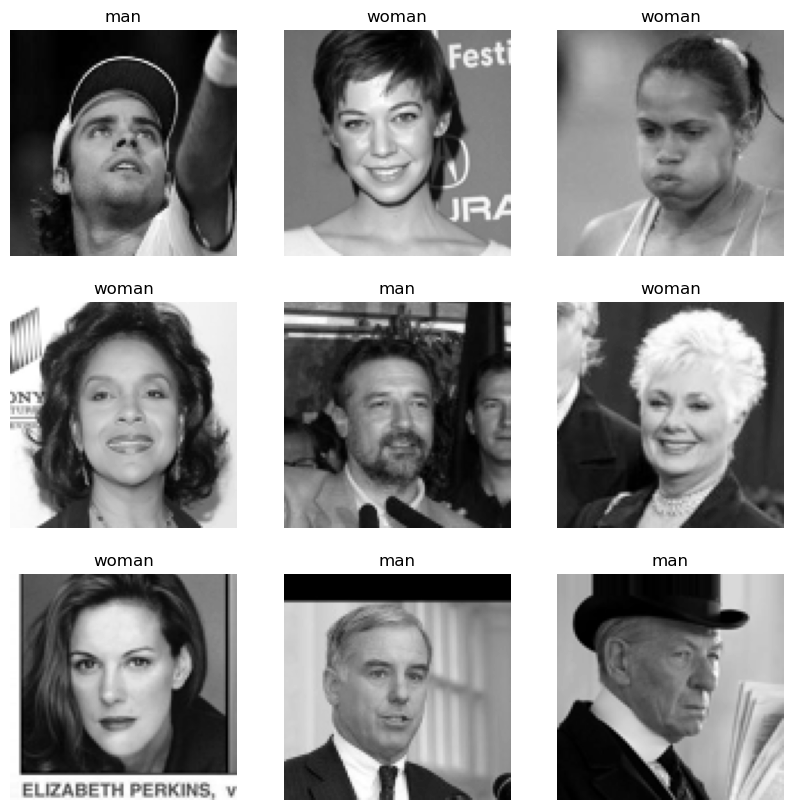

In [12]:
#visualizing how dataset looks like
plt.figure(figsize=(10, 10))
for images, labels in train_data_clean.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

###  Dataset 2

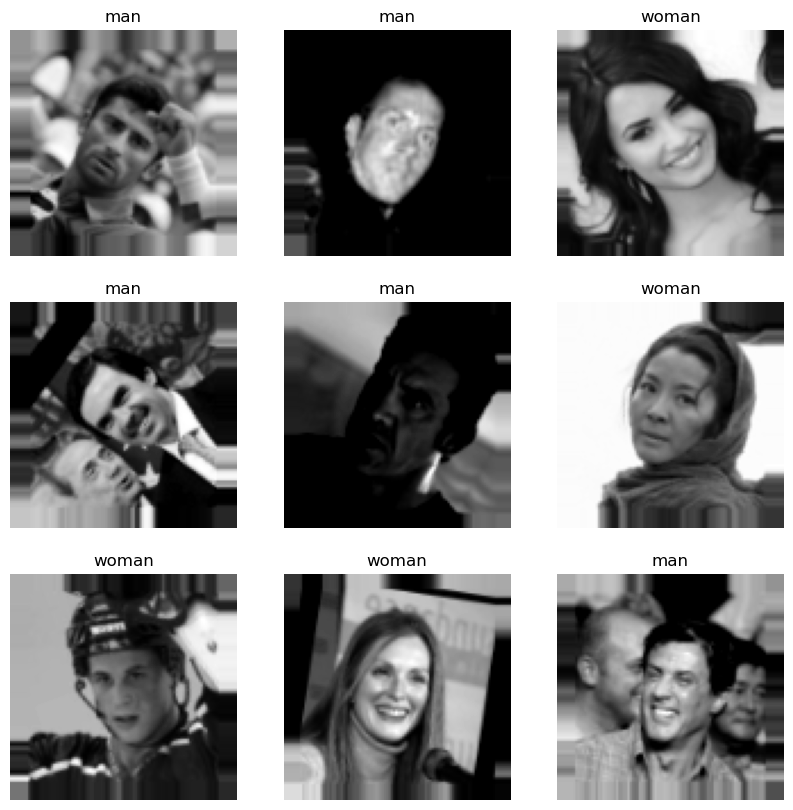

In [13]:
#randomly rotating, zooming and fliping horizontaly
#randomly changing brightness and contrast of the photos
preprocess = tf.keras.Sequential([
                   layers.RandomRotation(0.15),
                   layers.RandomZoom(height_factor= (.2, .1),
                                    fill_mode = 'nearest'),
                   layers.RandomFlip("horizontal"),
                   layers.RandomContrast(0.3),
                   layers.RandomBrightness(0.001)
                ])


train_data_clean2 = train_data_clean.map(
  lambda x, y: (preprocess(x, training=True), y))

plt.figure(figsize=(10, 10))
for images, labels in train_data_clean2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy(), cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Training

In [14]:
def model_history(model, train_data, val_data): #function for training purposes
    
    #setting Early Stopping callback: training will stop if validation loss doesn't improve after 5 epochs
    callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True)
    #training
    history = model.fit(train_data,
          batch_size=batch_size,
          epochs=50,
          validation_data=val_data,
          callbacks = callback)

    #plotting loss curve
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def model_evaluate(model, y_true, test_data): #function for evaluation 
    
    images, labels = tuple(zip(*test_data.unbatch()))
    true_class = np.array(labels)
    #getting predicted classes
    pred_class = (model.predict(test_data) > 0.5).astype("int32")
    pred_class = [item for sublist in pred_class for item in sublist]
    
    #confusion matrix
    cm = confusion_matrix(true_class.tolist(), pred_class, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])
    disp.plot()

    results = model.evaluate(test_data)
    print("Evaluation on test set:")
    print("Accuracy:", results[1])
    print("Loss:", results[0])

#extracting correct classes from test data    
images, labels = tuple(zip(*test_data.unbatch()))
true_class = np.array(labels)


def reinitialize(model): #function for reseting weights of model 
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))


AUTOTUNE = tf.data.AUTOTUNE
train_data_clean = train_data_clean.cache().prefetch(buffer_size=AUTOTUNE)
train_data_clean2 = train_data_clean2.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

#setting seed for consistency of training
tf.random.set_seed(123)

# Dataset 1

### Models

**In CNN and NN models we will be using reLU activation for hidden layers as it seems the most suitable, and sigmoid activation for output layers because we are dealing with binary task.**

In [15]:
#CNN MODELS

#architecture of first CNN model:
#input layer with 32 filters 5x5 kernel size + reLU activation
#two hidden convolutional layers, each followed by Max Pooling with 2x2 filter size and dropout + reLU activation
#fully connected hidden layer with 100 units + reLU activation
#output layer with sigmoid activation
model1_CNN = keras.models.Sequential([
             keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape = [100, 100, 1]),
             keras.layers.MaxPooling2D(2,2),
             keras.layers.Conv2D(64, (3, 3), activation='relu'),
             keras.layers.MaxPooling2D(2,2),
             keras.layers.Dropout(0.6),
             keras.layers.Conv2D(64, (3, 3), activation='relu'),
             keras.layers.MaxPooling2D(2,2),
             keras.layers.Dropout(0.5),
             keras.layers.Flatten(),
             keras.layers.Dense(100, activation='relu'),
             keras.layers.Dense(1, activation ='sigmoid')
             ])

#second CNN model has only one hidden convolutional layer, besides this, its architecture is same as the first one
model2_CNN = keras.models.Sequential([
             keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape = [100, 100, 1]),
             keras.layers.MaxPooling2D(2,2),
             keras.layers.Conv2D(64, (3, 3), activation='relu'),
             keras.layers.MaxPooling2D(2,2),
             keras.layers.Dropout(0.5),
             keras.layers.Flatten(),
             keras.layers.Dense(100, activation='relu'),
             keras.layers.Dense(1, activation ='sigmoid')
             ])


#NN MODELS
#to fit images into NN model without convolution we first need to flatten our input to 1D

#first NN model consists of:
#non-trainable flatten layer (to fit images into NN model without convolution we first need to flatten our input to 1D)
#input layer with 300 nodes
#three hidden fully connected layers with 100 nodes, each followed by dropout
#output layer with sigmoid activation
model1_NN = keras.models.Sequential([keras.layers.Flatten(),
            keras.layers.Dense(300, activation = 'relu' ),
            keras.layers.Dense(100, activation = 'relu' ),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(100, activation = 'relu' ),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(100, activation = 'relu' ),
            keras.layers.Dropout(0.2) ,                   
            keras.layers.Dense(1, activation = 'sigmoid' )])

#second model has only one hidden layer followed by dropout
model2_NN = keras.models.Sequential([keras.layers.Flatten(),
            keras.layers.Dense(300, activation = 'relu' ),
            keras.layers.Dense(200, activation = 'relu' ),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation = 'sigmoid' )])


#KNN MODELS 

model1_KNN = KNeighborsClassifier(n_neighbors=7)
model2_KNN = KNeighborsClassifier(n_neighbors=10)

## CNN

Epoch 1/50
337/337 [==============================] - 16s 42ms/step - loss: 0.5711 - binary_accuracy: 0.6833 - val_loss: 0.4691 - val_binary_accuracy: 0.7691
Epoch 2/50
337/337 [==============================] - 5s 15ms/step - loss: 0.4496 - binary_accuracy: 0.7835 - val_loss: 0.3887 - val_binary_accuracy: 0.8318
Epoch 3/50
337/337 [==============================] - 5s 14ms/step - loss: 0.3794 - binary_accuracy: 0.8259 - val_loss: 0.3570 - val_binary_accuracy: 0.8385
Epoch 4/50
337/337 [==============================] - 5s 15ms/step - loss: 0.3347 - binary_accuracy: 0.8500 - val_loss: 0.3357 - val_binary_accuracy: 0.8512
Epoch 5/50
337/337 [==============================] - 5s 14ms/step - loss: 0.2969 - binary_accuracy: 0.8713 - val_loss: 0.3155 - val_binary_accuracy: 0.8619
Epoch 6/50
337/337 [==============================] - 5s 14ms/step - loss: 0.2723 - binary_accuracy: 0.8816 - val_loss: 0.2868 - val_binary_accuracy: 0.8734
Epoch 7/50
337/337 [==============================] - 5s 

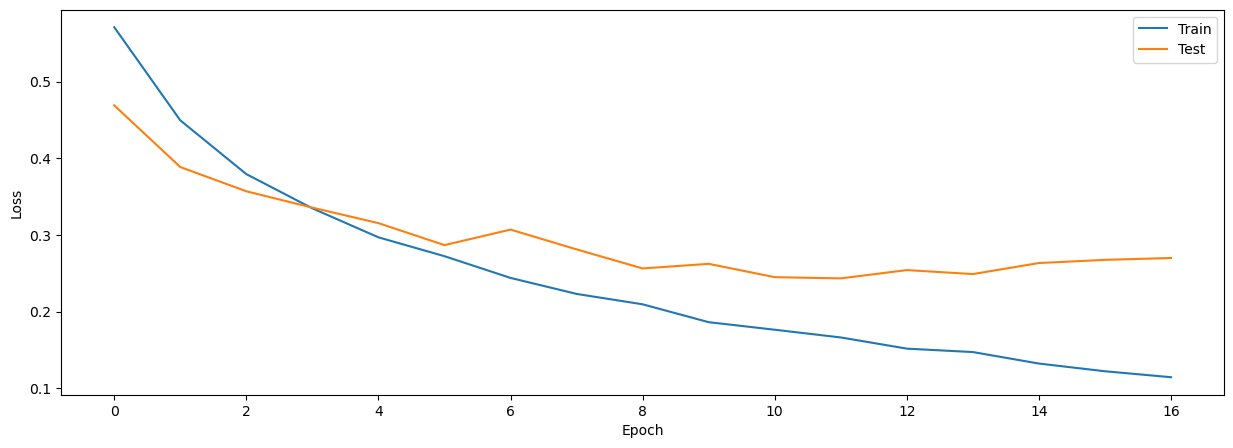

43/43 [==============================] - 0s 5ms/step - loss: 0.2471 - binary_accuracy: 0.9013
Evaluation on test set:
Accuracy: 0.901262104511261
Loss: 0.2471473664045334


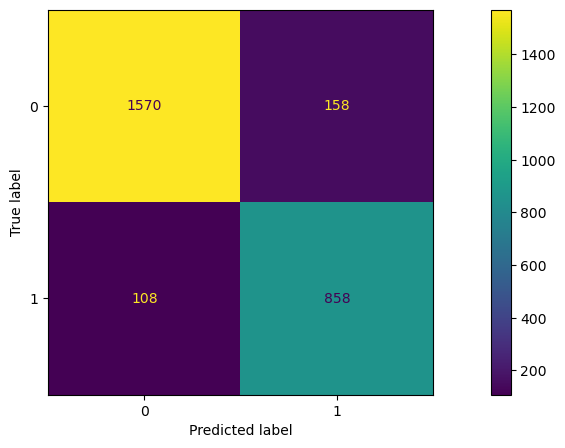

In [16]:
model1_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_CNN, train_data_clean, val_data)
model_evaluate(model1_CNN, true_class, test_data)
reinitialize(model1_CNN)

Epoch 1/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6877 - binary_accuracy: 0.5423 - val_loss: 0.6814 - val_binary_accuracy: 0.6559
Epoch 2/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6587 - binary_accuracy: 0.6115 - val_loss: 0.6571 - val_binary_accuracy: 0.6359
Epoch 3/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6144 - binary_accuracy: 0.6667 - val_loss: 0.6344 - val_binary_accuracy: 0.6455
Epoch 4/50
337/337 [==============================] - 5s 15ms/step - loss: 0.5815 - binary_accuracy: 0.6999 - val_loss: 0.6012 - val_binary_accuracy: 0.6860
Epoch 5/50
337/337 [==============================] - 5s 15ms/step - loss: 0.5542 - binary_accuracy: 0.7200 - val_loss: 0.5582 - val_binary_accuracy: 0.7220
Epoch 6/50
337/337 [==============================] - 5s 15ms/step - loss: 0.5282 - binary_accuracy: 0.7357 - val_loss: 0.5414 - val_binary_accuracy: 0.7235
Epoch 7/50
337/337 [==============================] - 5s 1

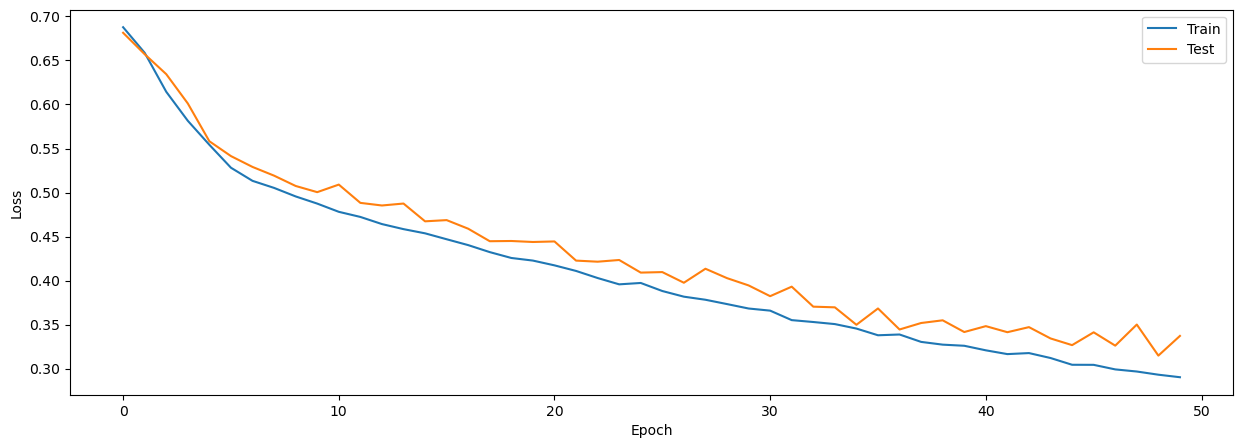

43/43 [==============================] - 0s 5ms/step - loss: 0.3265 - binary_accuracy: 0.8497
Evaluation on test set:
Accuracy: 0.8496659398078918
Loss: 0.32646679878234863


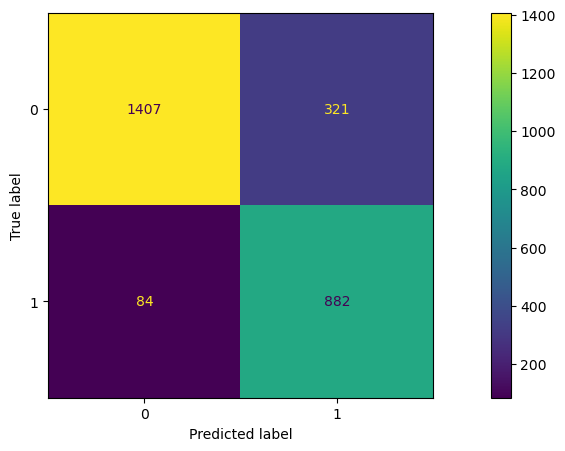

In [17]:
model1_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])


model_history(model1_CNN, train_data_clean, val_data)
model_evaluate(model1_CNN, true_class, test_data)
reinitialize(model1_CNN)

Epoch 1/50
337/337 [==============================] - 5s 14ms/step - loss: 0.4771 - accuracy: 0.7608 - val_loss: 0.3835 - val_accuracy: 0.8333
Epoch 2/50
337/337 [==============================] - 5s 14ms/step - loss: 0.3478 - accuracy: 0.8426 - val_loss: 0.3408 - val_accuracy: 0.8467
Epoch 3/50
337/337 [==============================] - 5s 14ms/step - loss: 0.2879 - accuracy: 0.8761 - val_loss: 0.3376 - val_accuracy: 0.8534
Epoch 4/50
337/337 [==============================] - 5s 14ms/step - loss: 0.2415 - accuracy: 0.9000 - val_loss: 0.3532 - val_accuracy: 0.8452
Epoch 5/50
337/337 [==============================] - 5s 13ms/step - loss: 0.2074 - accuracy: 0.9159 - val_loss: 0.3387 - val_accuracy: 0.8589
Epoch 6/50
337/337 [==============================] - 5s 13ms/step - loss: 0.1687 - accuracy: 0.9312 - val_loss: 0.3408 - val_accuracy: 0.8653
Epoch 7/50
337/337 [==============================] - 5s 14ms/step - loss: 0.1419 - accuracy: 0.9447 - val_loss: 0.3352 - val_accuracy: 0.8675

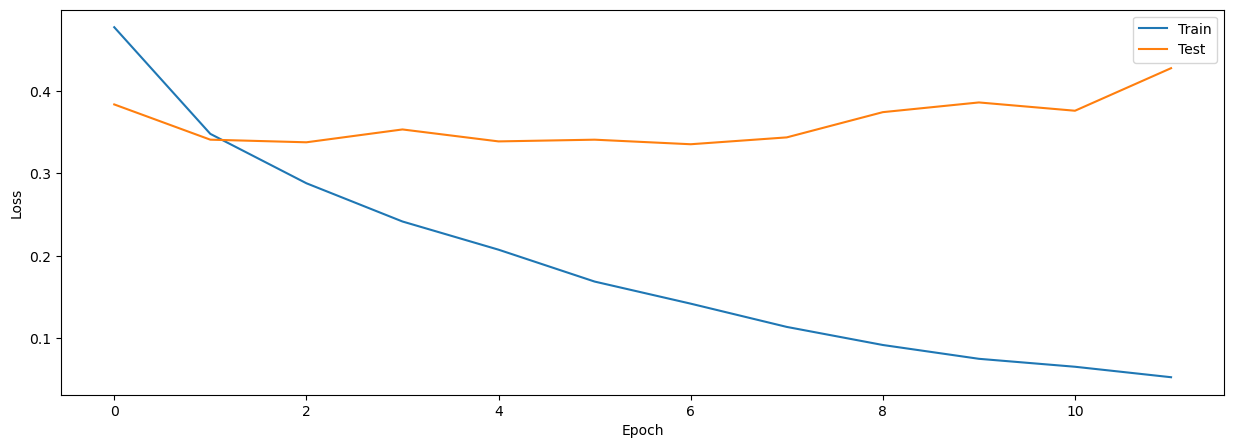

43/43 [==============================] - 0s 5ms/step - loss: 0.3127 - accuracy: 0.8738
Evaluation on test set:
Accuracy: 0.8737936615943909
Loss: 0.31267184019088745


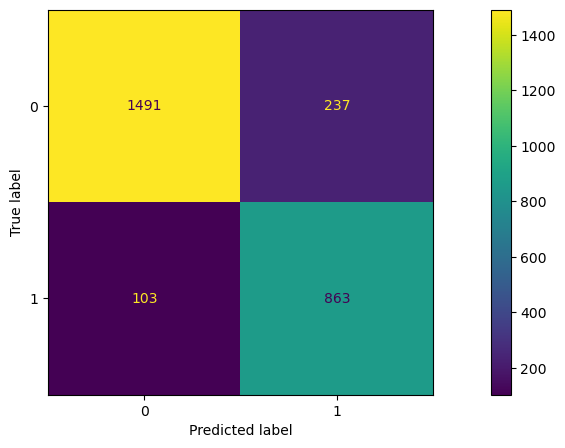

In [18]:
model2_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=['accuracy'])


model_history(model2_CNN, train_data_clean, val_data)
model_evaluate(model2_CNN, true_class, test_data)
reinitialize(model2_CNN)

Epoch 1/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6609 - binary_accuracy: 0.6102 - val_loss: 0.6163 - val_binary_accuracy: 0.6596
Epoch 2/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5868 - binary_accuracy: 0.6883 - val_loss: 0.5795 - val_binary_accuracy: 0.7079
Epoch 3/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5452 - binary_accuracy: 0.7218 - val_loss: 0.5524 - val_binary_accuracy: 0.7257
Epoch 4/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5131 - binary_accuracy: 0.7452 - val_loss: 0.5360 - val_binary_accuracy: 0.7279
Epoch 5/50
337/337 [==============================] - 5s 14ms/step - loss: 0.4877 - binary_accuracy: 0.7585 - val_loss: 0.5127 - val_binary_accuracy: 0.7442
Epoch 6/50
337/337 [==============================] - 5s 14ms/step - loss: 0.4710 - binary_accuracy: 0.7714 - val_loss: 0.4943 - val_binary_accuracy: 0.7535
Epoch 7/50
337/337 [==============================] - 5s 1

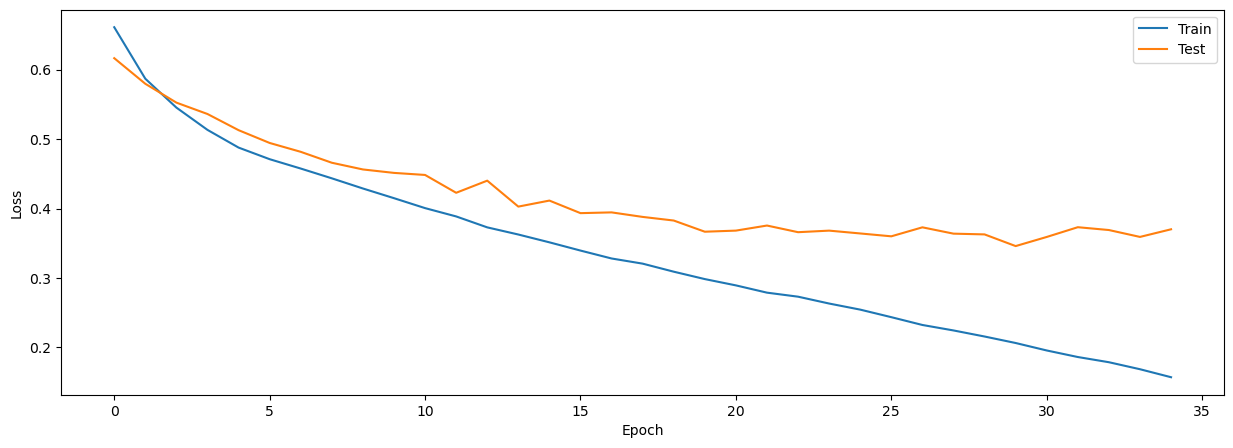

43/43 [==============================] - 0s 4ms/step - loss: 0.3321 - binary_accuracy: 0.8582
Evaluation on test set:
Accuracy: 0.8582034111022949
Loss: 0.3320859670639038


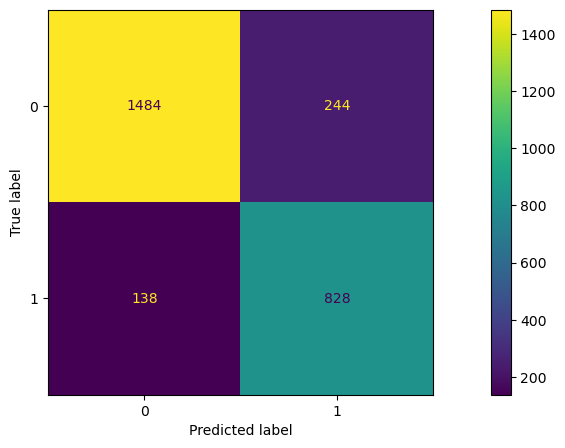

In [19]:
model2_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_CNN, train_data_clean, val_data)
model_evaluate(model2_CNN, true_class, test_data)
reinitialize(model2_CNN)

## Simple neural network

Epoch 1/50
337/337 [==============================] - 2s 6ms/step - loss: 0.7129 - binary_accuracy: 0.5128 - val_loss: 0.6896 - val_binary_accuracy: 0.6488
Epoch 2/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6922 - binary_accuracy: 0.5042 - val_loss: 0.6886 - val_binary_accuracy: 0.3764
Epoch 3/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6933 - binary_accuracy: 0.5004 - val_loss: 0.6887 - val_binary_accuracy: 0.6488
Epoch 4/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6932 - binary_accuracy: 0.5072 - val_loss: 0.6891 - val_binary_accuracy: 0.6488
Epoch 5/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6931 - binary_accuracy: 0.5039 - val_loss: 0.6889 - val_binary_accuracy: 0.6488
Epoch 6/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6932 - binary_accuracy: 0.5045 - val_loss: 0.6890 - val_binary_accuracy: 0.6488
Epoch 7/50
337/337 [==============================] - 2s 5ms/ste

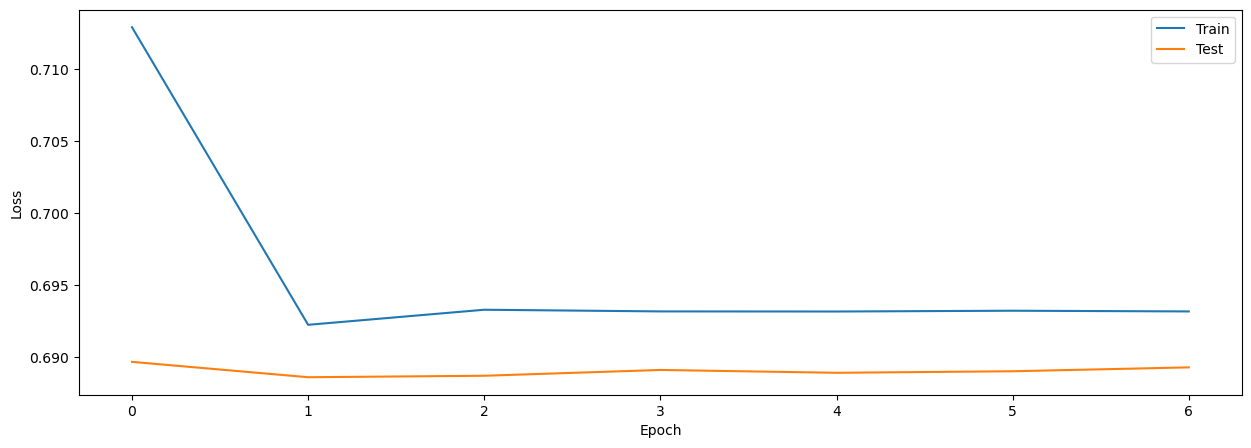

43/43 [==============================] - 0s 4ms/step - loss: 0.6879 - binary_accuracy: 0.3805
Evaluation on test set:
Accuracy: 0.38047513365745544
Loss: 0.6879445910453796


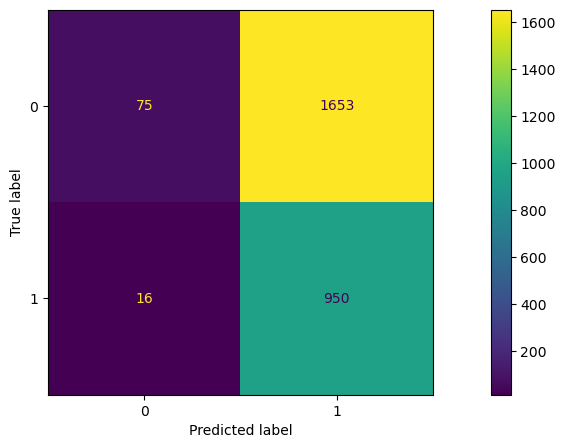

In [40]:
model1_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean, val_data)
model_evaluate(model1_NN, true_class, test_data)
reinitialize(model1_NN)

Epoch 1/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6675 - binary_accuracy: 0.5827 - val_loss: 0.6277 - val_binary_accuracy: 0.6444
Epoch 2/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6221 - binary_accuracy: 0.6575 - val_loss: 0.5822 - val_binary_accuracy: 0.6863
Epoch 3/50
337/337 [==============================] - 2s 6ms/step - loss: 0.5953 - binary_accuracy: 0.6848 - val_loss: 0.5990 - val_binary_accuracy: 0.6659
Epoch 4/50
337/337 [==============================] - 2s 6ms/step - loss: 0.5734 - binary_accuracy: 0.7032 - val_loss: 0.5484 - val_binary_accuracy: 0.7194
Epoch 5/50
337/337 [==============================] - 2s 6ms/step - loss: 0.5621 - binary_accuracy: 0.7188 - val_loss: 0.5633 - val_binary_accuracy: 0.7056
Epoch 6/50
337/337 [==============================] - 2s 6ms/step - loss: 0.5535 - binary_accuracy: 0.7219 - val_loss: 0.5467 - val_binary_accuracy: 0.7190
Epoch 7/50
337/337 [==============================] - 2s 6ms/ste

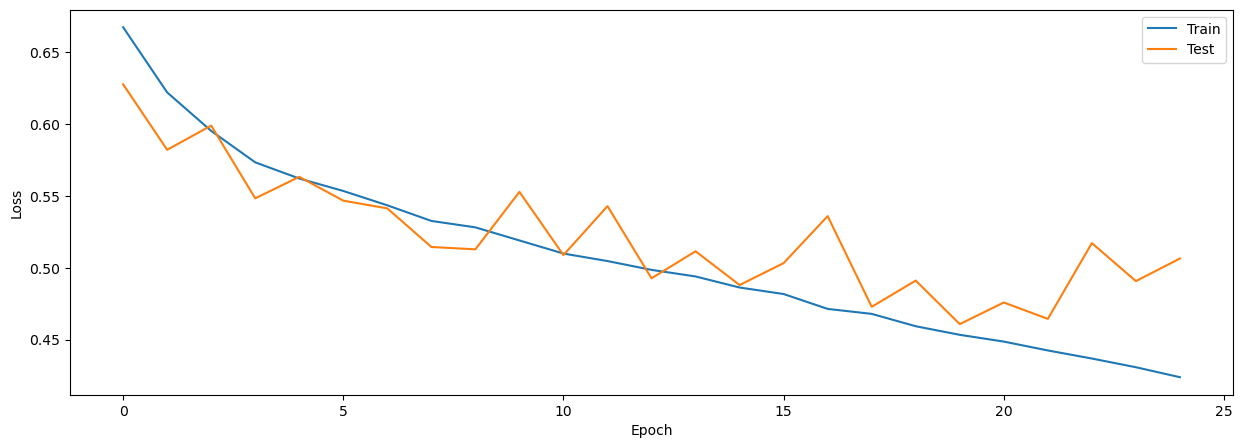

43/43 [==============================] - 0s 3ms/step - loss: 0.4474 - binary_accuracy: 0.7817
Evaluation on test set:
Accuracy: 0.781737208366394
Loss: 0.44737479090690613


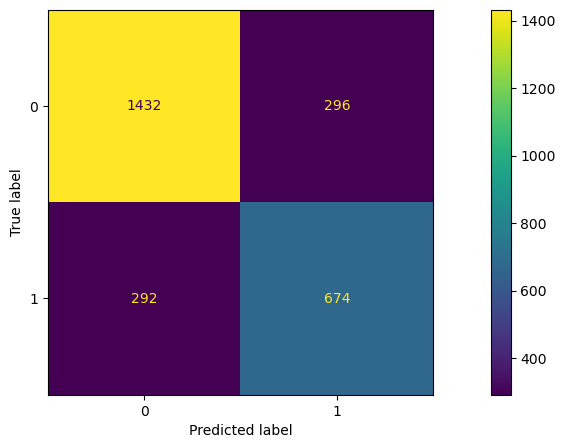

In [21]:
model1_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean, val_data)
model_evaluate(model1_NN, true_class, test_data)
reinitialize(model1_NN)

Epoch 1/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6826 - binary_accuracy: 0.6523 - val_loss: 0.5347 - val_binary_accuracy: 0.7268
Epoch 2/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5612 - binary_accuracy: 0.7064 - val_loss: 0.5412 - val_binary_accuracy: 0.7235
Epoch 3/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5371 - binary_accuracy: 0.7239 - val_loss: 0.5378 - val_binary_accuracy: 0.7138
Epoch 4/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5204 - binary_accuracy: 0.7354 - val_loss: 0.5056 - val_binary_accuracy: 0.7416
Epoch 5/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5116 - binary_accuracy: 0.7444 - val_loss: 0.5073 - val_binary_accuracy: 0.7405
Epoch 6/50
337/337 [==============================] - 2s 5ms/step - loss: 0.4972 - binary_accuracy: 0.7518 - val_loss: 0.5080 - val_binary_accuracy: 0.7428
Epoch 7/50
337/337 [==============================] - 2s 5ms/ste

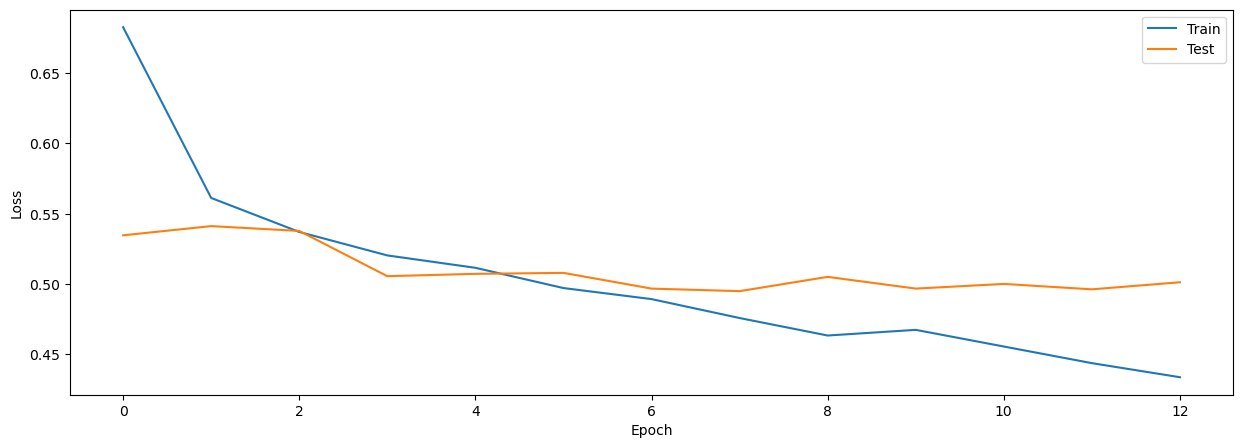

43/43 [==============================] - 0s 3ms/step - loss: 0.4690 - binary_accuracy: 0.7725
Evaluation on test set:
Accuracy: 0.7724573612213135
Loss: 0.46903809905052185


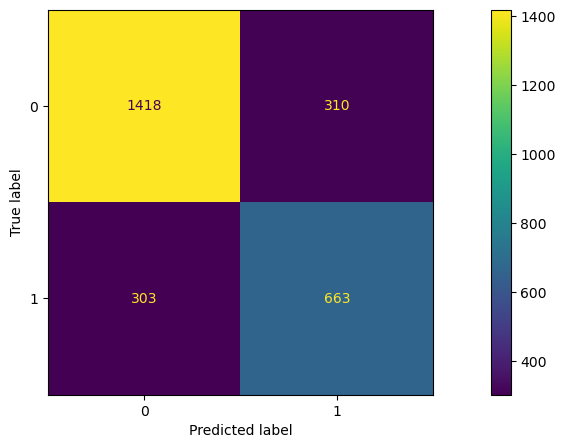

In [22]:
model2_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_NN, train_data_clean, val_data)
model_evaluate(model2_NN, true_class, test_data)
reinitialize(model2_NN)

Epoch 1/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6206 - binary_accuracy: 0.6535 - val_loss: 0.5935 - val_binary_accuracy: 0.6797
Epoch 2/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5597 - binary_accuracy: 0.7129 - val_loss: 0.5748 - val_binary_accuracy: 0.6927
Epoch 3/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5350 - binary_accuracy: 0.7289 - val_loss: 0.5406 - val_binary_accuracy: 0.7190
Epoch 4/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5194 - binary_accuracy: 0.7389 - val_loss: 0.5587 - val_binary_accuracy: 0.7056
Epoch 5/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5068 - binary_accuracy: 0.7462 - val_loss: 0.5372 - val_binary_accuracy: 0.7201
Epoch 6/50
337/337 [==============================] - 2s 5ms/step - loss: 0.4965 - binary_accuracy: 0.7547 - val_loss: 0.5240 - val_binary_accuracy: 0.7313
Epoch 7/50
337/337 [==============================] - 2s 5ms/ste

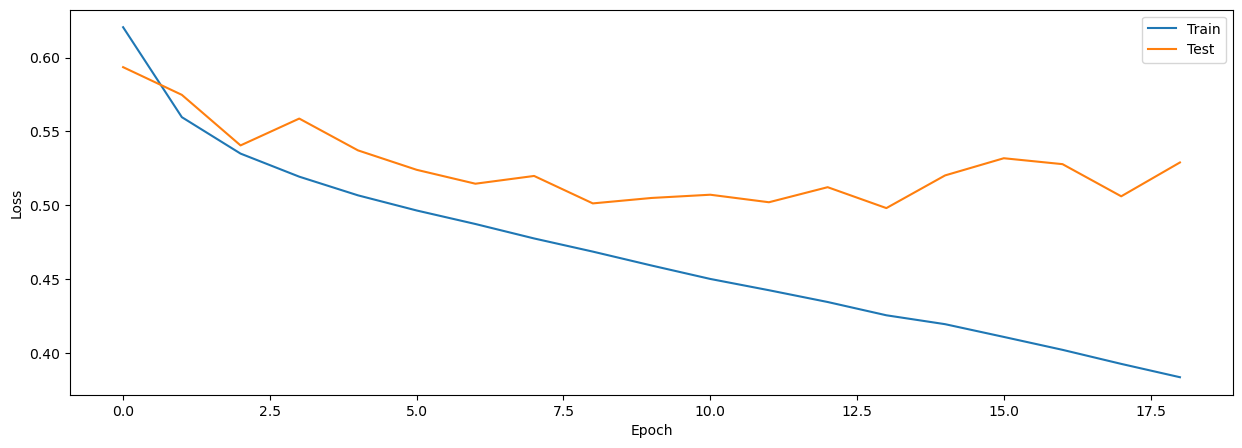

43/43 [==============================] - 0s 3ms/step - loss: 0.4842 - binary_accuracy: 0.7661
Evaluation on test set:
Accuracy: 0.7661470174789429
Loss: 0.48422589898109436


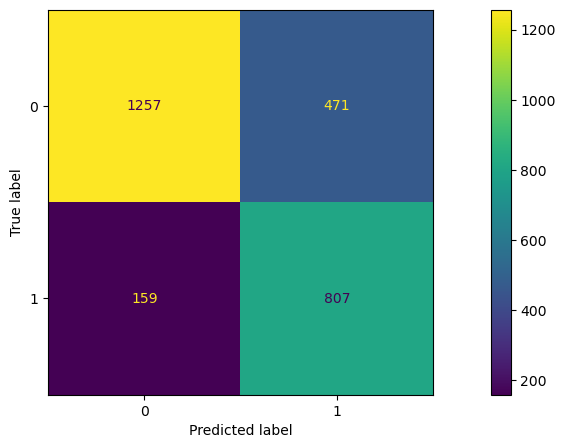

In [23]:
model2_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])


model_history(model2_NN, train_data_clean, val_data)
model_evaluate(model2_NN, true_class, test_data)
reinitialize(model2_NN)

### KNN

In [24]:
#processing tf dataset to fit into KNN model

images, labels = tuple(zip(*train_data_clean.unbatch()))
images = np.array(images)
y_train = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_train = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Train set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_train.shape)

images, labels = tuple(zip(*test_data.unbatch()))
images = np.array(images)
y_test = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_test = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Test set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_test.shape)

Train set:
Before reshaping: (21568, 100, 100, 1)
After reshaping: (21568, 10000)
Test set:
Before reshaping: (2694, 100, 100, 1)
After reshaping: (2694, 10000)


              precision    recall  f1-score   support

           0       0.58      0.81      0.68      1243
           1       0.75      0.50      0.60      1451

    accuracy                           0.64      2694
   macro avg       0.67      0.66      0.64      2694
weighted avg       0.68      0.64      0.64      2694



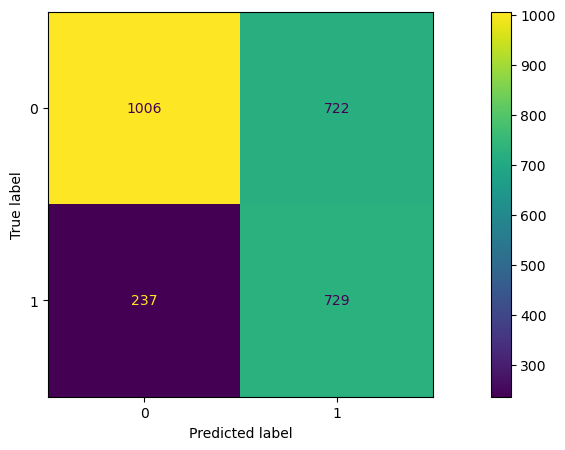

In [25]:
model1_KNN.fit(x_train,y_train)
y_pred_KNN=model1_KNN.predict(x_test)


cm = confusion_matrix(y_test, y_pred_KNN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])

print(classification_report(y_pred_KNN,y_test))
disp.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1438
           1       0.70      0.54      0.61      1256

    accuracy                           0.68      2694
   macro avg       0.68      0.67      0.67      2694
weighted avg       0.68      0.68      0.67      2694



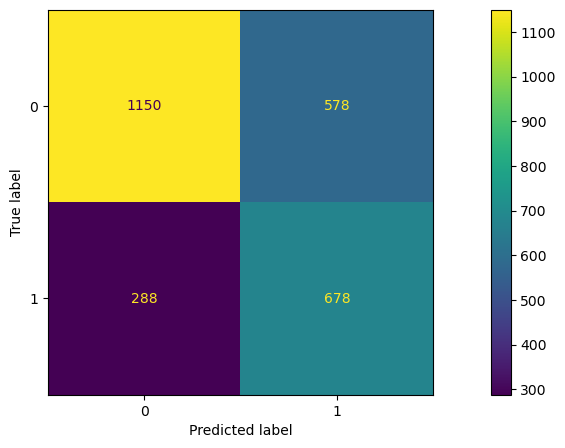

In [26]:
model2_KNN.fit(x_train,y_train)
y_pred_KNN=model2_KNN.predict(x_test)


cm = confusion_matrix(y_test, y_pred_KNN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])

print(classification_report(y_pred_KNN,y_test))
disp.plot()
plt.show()

# Dataset 2 (augumented)

## CNN

Epoch 1/50
337/337 [==============================] - 117s 339ms/step - loss: 0.6715 - binary_accuracy: 0.5746 - val_loss: 0.6005 - val_binary_accuracy: 0.6641
Epoch 2/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5819 - binary_accuracy: 0.6901 - val_loss: 0.5701 - val_binary_accuracy: 0.6882
Epoch 3/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5414 - binary_accuracy: 0.7229 - val_loss: 0.5357 - val_binary_accuracy: 0.7205
Epoch 4/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5137 - binary_accuracy: 0.7406 - val_loss: 0.5237 - val_binary_accuracy: 0.7249
Epoch 5/50
337/337 [==============================] - 5s 14ms/step - loss: 0.4895 - binary_accuracy: 0.7594 - val_loss: 0.5384 - val_binary_accuracy: 0.7112
Epoch 6/50
337/337 [==============================] - 5s 14ms/step - loss: 0.4660 - binary_accuracy: 0.7717 - val_loss: 0.4983 - val_binary_accuracy: 0.7413
Epoch 7/50
337/337 [==============================] - 5

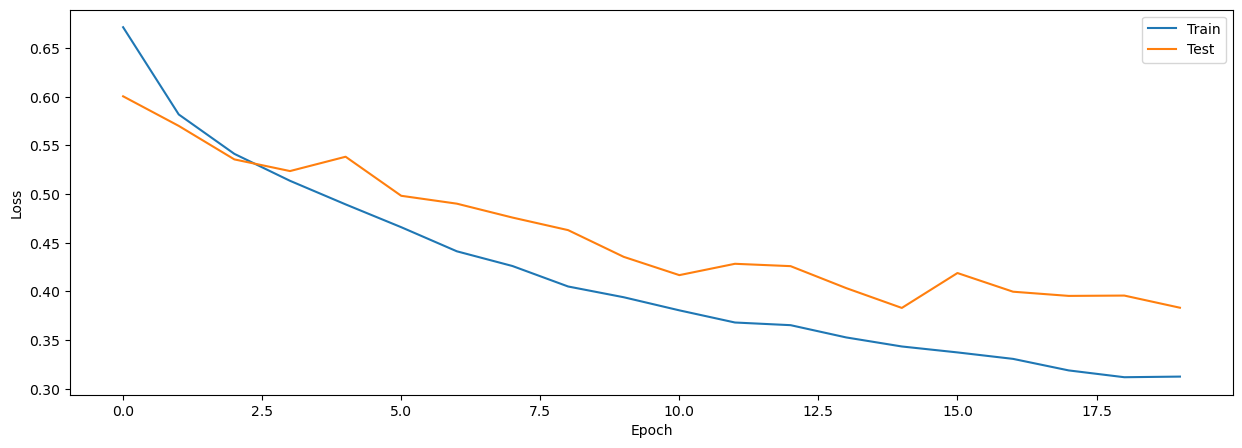

43/43 [==============================] - 0s 5ms/step - loss: 0.4029 - binary_accuracy: 0.8174
Evaluation on test set:
Accuracy: 0.8173719644546509
Loss: 0.40289637446403503


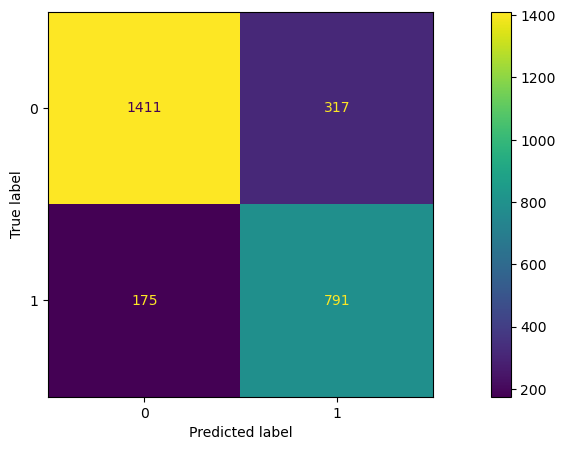

In [27]:
model1_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_CNN, train_data_clean2, val_data)
model_evaluate(model1_CNN, true_class, test_data)
reinitialize(model1_CNN)

Epoch 1/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6923 - binary_accuracy: 0.5176 - val_loss: 0.6903 - val_binary_accuracy: 0.6043
Epoch 2/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6861 - binary_accuracy: 0.5612 - val_loss: 0.6859 - val_binary_accuracy: 0.5869
Epoch 3/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6738 - binary_accuracy: 0.5899 - val_loss: 0.6683 - val_binary_accuracy: 0.6429
Epoch 4/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6536 - binary_accuracy: 0.6191 - val_loss: 0.6406 - val_binary_accuracy: 0.6756
Epoch 5/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6283 - binary_accuracy: 0.6531 - val_loss: 0.6013 - val_binary_accuracy: 0.6956
Epoch 6/50
337/337 [==============================] - 5s 15ms/step - loss: 0.6065 - binary_accuracy: 0.6728 - val_loss: 0.5851 - val_binary_accuracy: 0.6897
Epoch 7/50
337/337 [==============================] - 5s 1

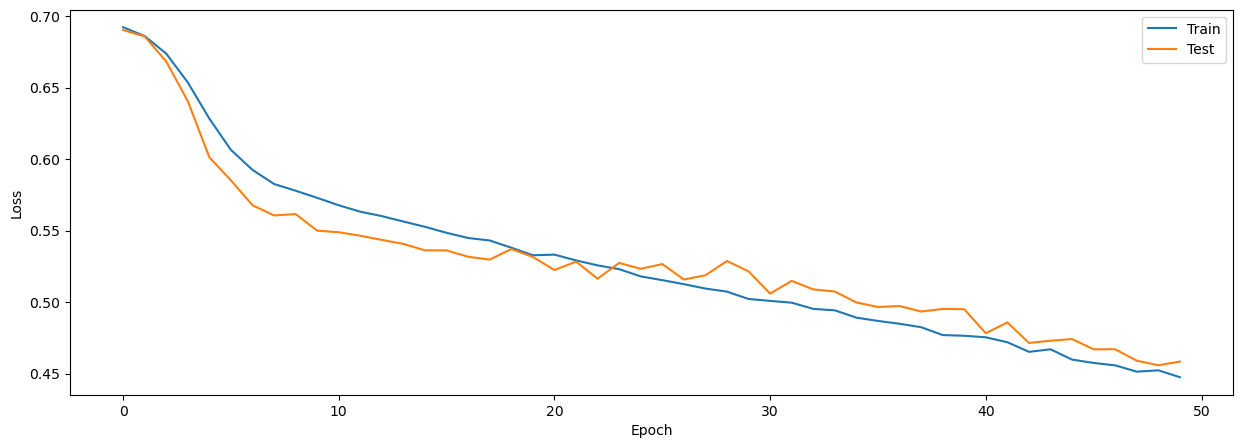

43/43 [==============================] - 0s 5ms/step - loss: 0.4517 - binary_accuracy: 0.7695
Evaluation on test set:
Accuracy: 0.7694877982139587
Loss: 0.4517093300819397


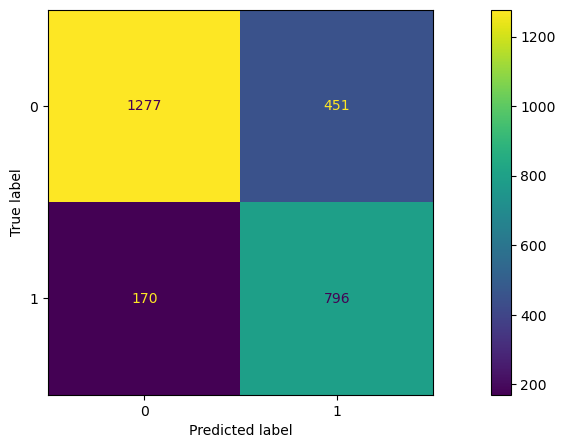

In [28]:
model1_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_CNN, train_data_clean2, val_data)
model_evaluate(model1_CNN, true_class, test_data)
reinitialize(model1_CNN)

Epoch 1/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6219 - binary_accuracy: 0.6430 - val_loss: 0.5863 - val_binary_accuracy: 0.6789
Epoch 2/50
337/337 [==============================] - 5s 13ms/step - loss: 0.5296 - binary_accuracy: 0.7372 - val_loss: 0.5503 - val_binary_accuracy: 0.7164
Epoch 3/50
337/337 [==============================] - 5s 14ms/step - loss: 0.4908 - binary_accuracy: 0.7599 - val_loss: 0.5020 - val_binary_accuracy: 0.7491
Epoch 4/50
337/337 [==============================] - 5s 13ms/step - loss: 0.4577 - binary_accuracy: 0.7782 - val_loss: 0.5141 - val_binary_accuracy: 0.7435
Epoch 5/50
337/337 [==============================] - 5s 13ms/step - loss: 0.4292 - binary_accuracy: 0.7960 - val_loss: 0.4913 - val_binary_accuracy: 0.7676
Epoch 6/50
337/337 [==============================] - 5s 13ms/step - loss: 0.4055 - binary_accuracy: 0.8093 - val_loss: 0.4778 - val_binary_accuracy: 0.7739
Epoch 7/50
337/337 [==============================] - 5s 1

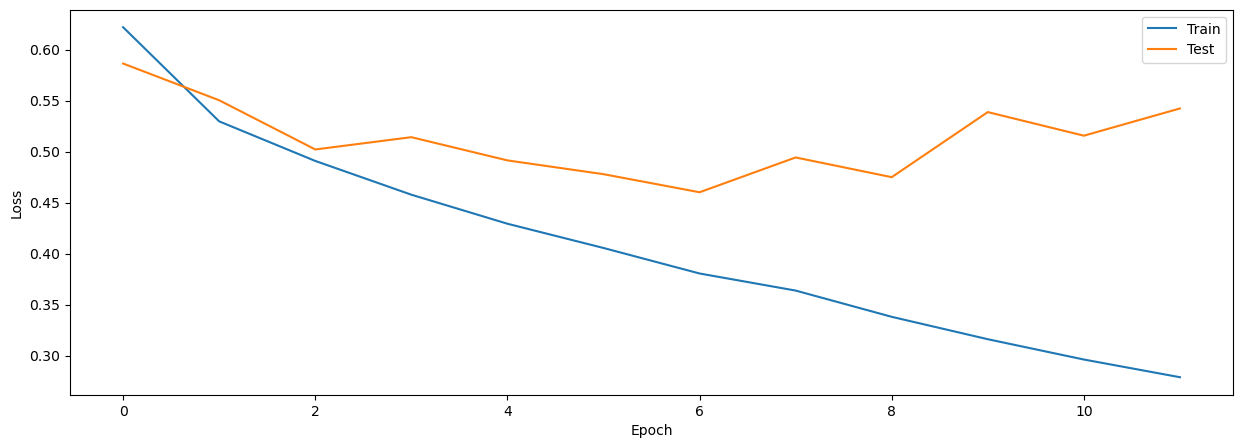

43/43 [==============================] - 0s 4ms/step - loss: 0.4485 - binary_accuracy: 0.7884
Evaluation on test set:
Accuracy: 0.788418710231781
Loss: 0.44846704602241516


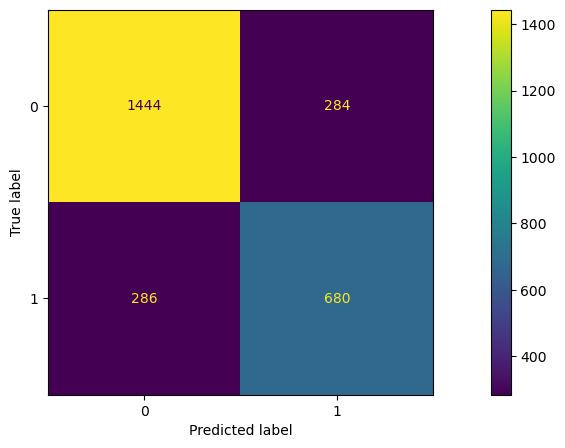

In [29]:
model2_CNN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_CNN, train_data_clean2, val_data)
model_evaluate(model2_CNN, true_class, test_data)
reinitialize(model2_CNN)

Epoch 1/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6864 - binary_accuracy: 0.5590 - val_loss: 0.6593 - val_binary_accuracy: 0.6592
Epoch 2/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6561 - binary_accuracy: 0.6155 - val_loss: 0.6026 - val_binary_accuracy: 0.6707
Epoch 3/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6261 - binary_accuracy: 0.6529 - val_loss: 0.5866 - val_binary_accuracy: 0.6841
Epoch 4/50
337/337 [==============================] - 5s 14ms/step - loss: 0.6054 - binary_accuracy: 0.6747 - val_loss: 0.5791 - val_binary_accuracy: 0.6871
Epoch 5/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5869 - binary_accuracy: 0.6925 - val_loss: 0.5620 - val_binary_accuracy: 0.7023
Epoch 6/50
337/337 [==============================] - 5s 14ms/step - loss: 0.5708 - binary_accuracy: 0.7073 - val_loss: 0.5501 - val_binary_accuracy: 0.7049
Epoch 7/50
337/337 [==============================] - 5s 1

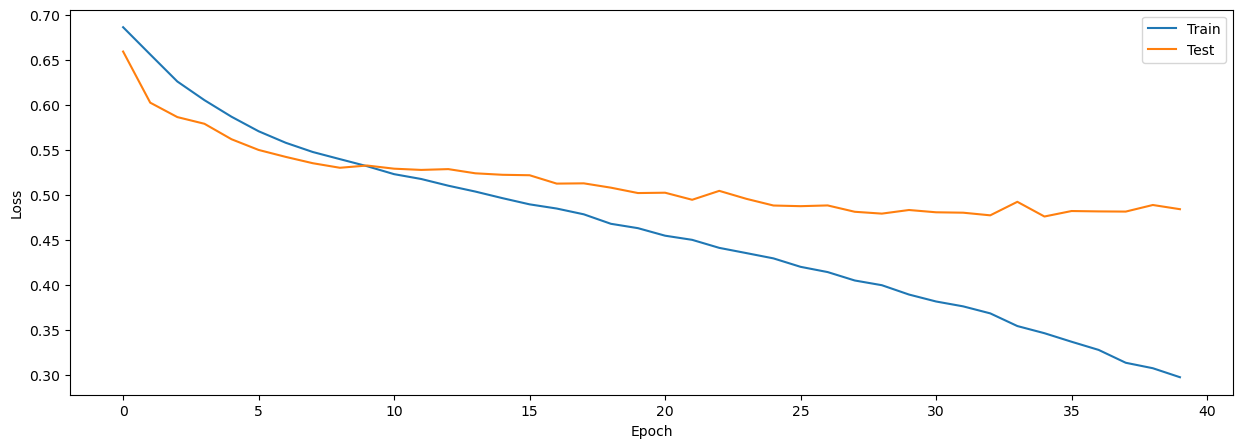

43/43 [==============================] - 0s 4ms/step - loss: 0.4699 - binary_accuracy: 0.7739
Evaluation on test set:
Accuracy: 0.7739421129226685
Loss: 0.4698534607887268


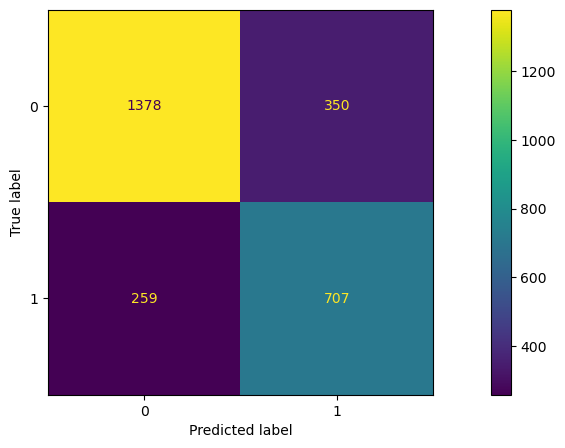

In [30]:
model2_CNN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_CNN, train_data_clean2, val_data)
model_evaluate(model2_CNN, true_class, test_data)
reinitialize(model2_CNN)

## Simple neural network

Epoch 1/50
337/337 [==============================] - 3s 6ms/step - loss: 0.7145 - binary_accuracy: 0.4999 - val_loss: 0.6945 - val_binary_accuracy: 0.3512
Epoch 2/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6940 - binary_accuracy: 0.5022 - val_loss: 0.6946 - val_binary_accuracy: 0.3512
Epoch 3/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6933 - binary_accuracy: 0.4991 - val_loss: 0.6930 - val_binary_accuracy: 0.6488
Epoch 4/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6936 - binary_accuracy: 0.4972 - val_loss: 0.6949 - val_binary_accuracy: 0.3512
Epoch 5/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6933 - binary_accuracy: 0.5023 - val_loss: 0.6935 - val_binary_accuracy: 0.3512
Epoch 6/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6932 - binary_accuracy: 0.5004 - val_loss: 0.6935 - val_binary_accuracy: 0.3512
Epoch 7/50
337/337 [==============================] - 2s 6ms/ste

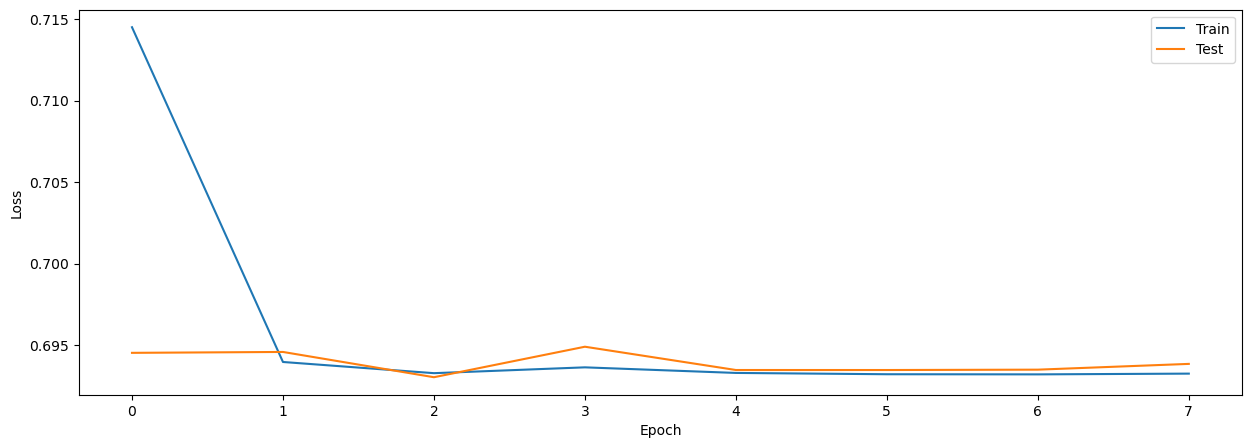

43/43 [==============================] - 0s 3ms/step - loss: 0.6930 - binary_accuracy: 0.6414
Evaluation on test set:
Accuracy: 0.6414254307746887
Loss: 0.6930360198020935


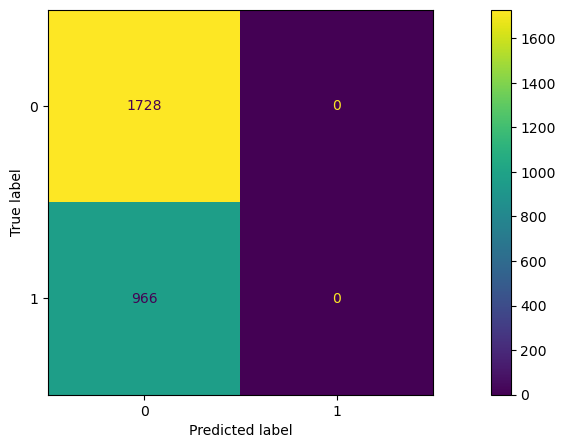

In [31]:
model1_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean2, val_data)
model_evaluate(model1_NN, true_class, test_data)
reinitialize(model1_NN)

Epoch 1/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6928 - binary_accuracy: 0.5287 - val_loss: 0.6715 - val_binary_accuracy: 0.6136
Epoch 2/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6788 - binary_accuracy: 0.5669 - val_loss: 0.6491 - val_binary_accuracy: 0.6366
Epoch 3/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6662 - binary_accuracy: 0.5946 - val_loss: 0.6115 - val_binary_accuracy: 0.6830
Epoch 4/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6534 - binary_accuracy: 0.6179 - val_loss: 0.6184 - val_binary_accuracy: 0.6737
Epoch 5/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6424 - binary_accuracy: 0.6360 - val_loss: 0.5983 - val_binary_accuracy: 0.6759
Epoch 6/50
337/337 [==============================] - 2s 6ms/step - loss: 0.6337 - binary_accuracy: 0.6457 - val_loss: 0.5914 - val_binary_accuracy: 0.6815
Epoch 7/50
337/337 [==============================] - 2s 6ms/ste

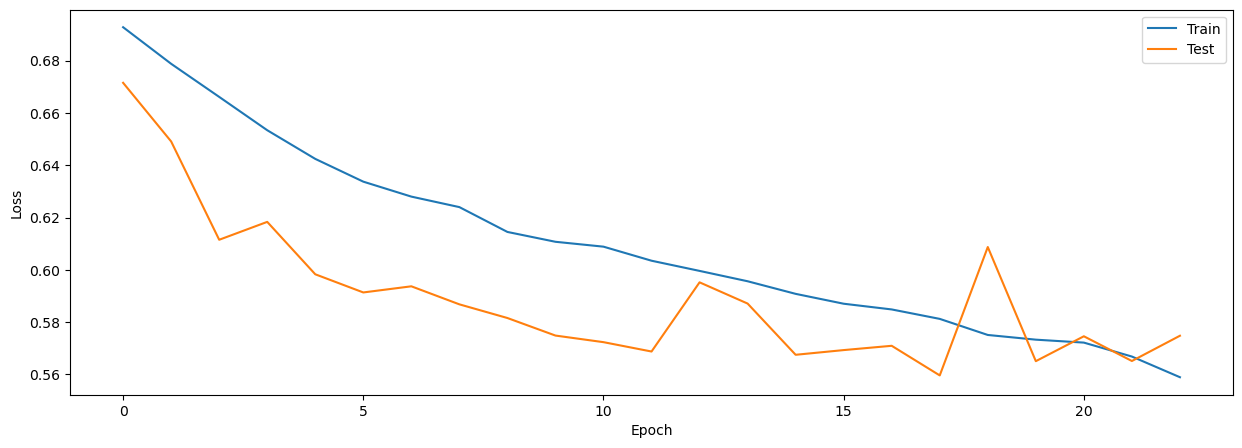

43/43 [==============================] - 0s 3ms/step - loss: 0.5395 - binary_accuracy: 0.7149
Evaluation on test set:
Accuracy: 0.7149220705032349
Loss: 0.5394698977470398


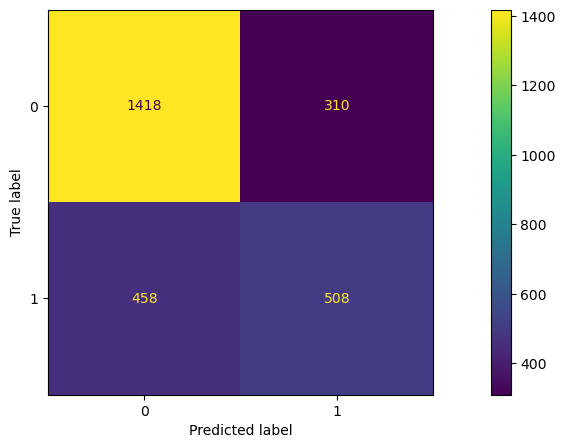

In [32]:
model1_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model1_NN, train_data_clean2, val_data)
model_evaluate(model1_NN, true_class, test_data)
reinitialize(model1_NN)

Epoch 1/50
337/337 [==============================] - 2s 5ms/step - loss: 0.7598 - binary_accuracy: 0.5668 - val_loss: 0.6336 - val_binary_accuracy: 0.6136
Epoch 2/50
337/337 [==============================] - 1s 4ms/step - loss: 0.6476 - binary_accuracy: 0.6205 - val_loss: 0.6319 - val_binary_accuracy: 0.6377
Epoch 3/50
337/337 [==============================] - 1s 4ms/step - loss: 0.6341 - binary_accuracy: 0.6371 - val_loss: 0.6384 - val_binary_accuracy: 0.6407
Epoch 4/50
337/337 [==============================] - 1s 4ms/step - loss: 0.6203 - binary_accuracy: 0.6550 - val_loss: 0.5858 - val_binary_accuracy: 0.6897
Epoch 5/50
337/337 [==============================] - 1s 4ms/step - loss: 0.6088 - binary_accuracy: 0.6686 - val_loss: 0.6364 - val_binary_accuracy: 0.6318
Epoch 6/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6033 - binary_accuracy: 0.6696 - val_loss: 0.5862 - val_binary_accuracy: 0.6886
Epoch 7/50
337/337 [==============================] - 1s 4ms/ste

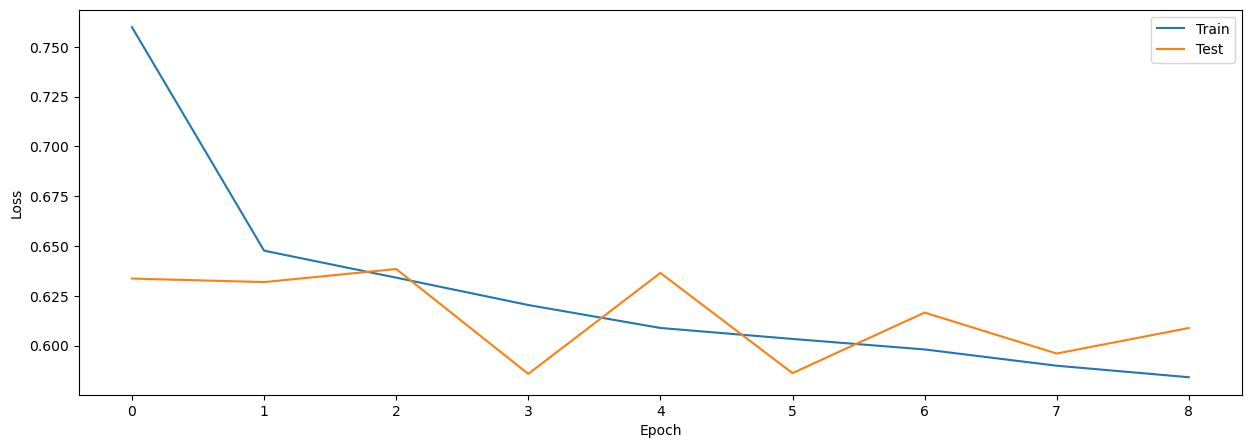

43/43 [==============================] - 0s 3ms/step - loss: 0.5624 - binary_accuracy: 0.7016
Evaluation on test set:
Accuracy: 0.7015590667724609
Loss: 0.5624449253082275


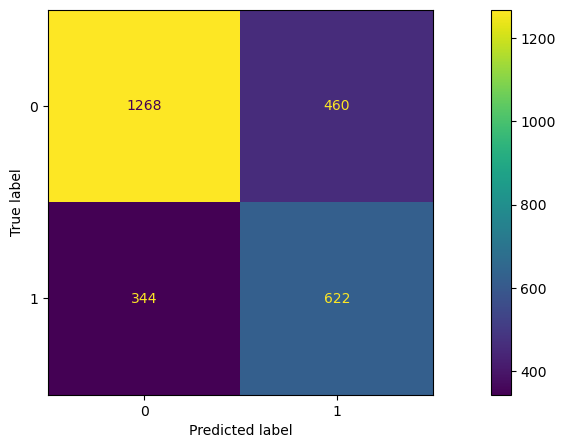

In [33]:
model2_NN.compile(optimizer='adam',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_NN, train_data_clean2, val_data)
model_evaluate(model2_NN, true_class, test_data)
reinitialize(model2_NN)

Epoch 1/50
337/337 [==============================] - 2s 7ms/step - loss: 0.6692 - binary_accuracy: 0.5939 - val_loss: 0.6131 - val_binary_accuracy: 0.6745
Epoch 2/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6368 - binary_accuracy: 0.6384 - val_loss: 0.5891 - val_binary_accuracy: 0.6971
Epoch 3/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6187 - binary_accuracy: 0.6560 - val_loss: 0.5743 - val_binary_accuracy: 0.7056
Epoch 4/50
337/337 [==============================] - 2s 5ms/step - loss: 0.6065 - binary_accuracy: 0.6724 - val_loss: 0.5797 - val_binary_accuracy: 0.6956
Epoch 5/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5949 - binary_accuracy: 0.6807 - val_loss: 0.5698 - val_binary_accuracy: 0.7042
Epoch 6/50
337/337 [==============================] - 2s 5ms/step - loss: 0.5884 - binary_accuracy: 0.6866 - val_loss: 0.5642 - val_binary_accuracy: 0.7157
Epoch 7/50
337/337 [==============================] - 2s 5ms/ste

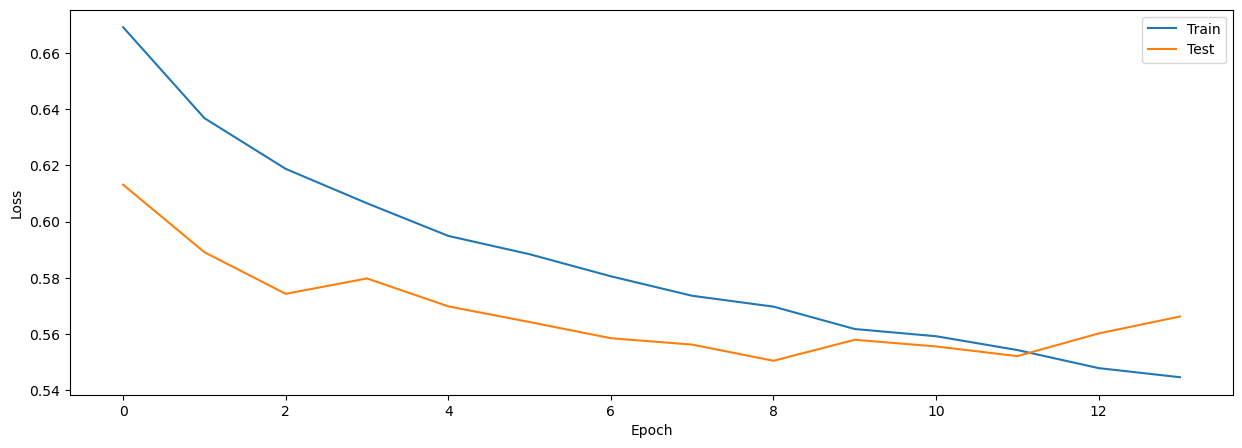

43/43 [==============================] - 0s 3ms/step - loss: 0.5308 - binary_accuracy: 0.7313
Evaluation on test set:
Accuracy: 0.7312546372413635
Loss: 0.5308014750480652


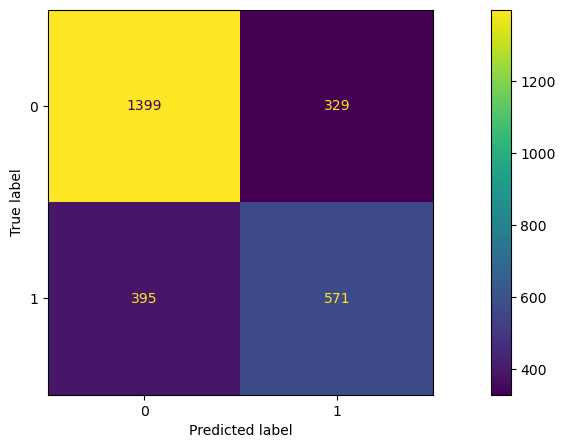

In [35]:
model2_NN.compile(optimizer='SGD',
             loss = 'binary_crossentropy',
             metrics=[tf.keras.metrics.BinaryAccuracy()])

model_history(model2_NN, train_data_clean2, val_data)
model_evaluate(model2_NN, true_class, test_data)
reinitialize(model2_NN)

## KNN

In [36]:
images, labels = tuple(zip(*train_data_clean2.unbatch()))
images = np.array(images)
y_train = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_train = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Train set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_train.shape)

images, labels = tuple(zip(*test_data.unbatch()))
images = np.array(images)
y_test = np.array(labels)
nsamples, nx, ny, nrgb = images.shape
x_test = images.reshape((nsamples,nx*ny*nrgb)) #reshaping from 4D to 2D
print("Test set:")
print("Before reshaping:",images.shape)
print("After reshaping:",x_test.shape)

Train set:
Before reshaping: (21568, 100, 100, 1)
After reshaping: (21568, 10000)
Test set:
Before reshaping: (2694, 100, 100, 1)
After reshaping: (2694, 10000)


              precision    recall  f1-score   support

           0       0.67      0.80      0.73      1438
           1       0.70      0.54      0.61      1256

    accuracy                           0.68      2694
   macro avg       0.68      0.67      0.67      2694
weighted avg       0.68      0.68      0.67      2694



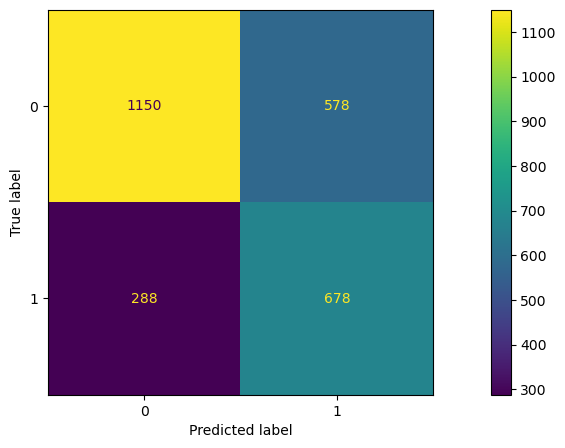

In [37]:
model1_KNN.fit(x_train,y_train)
y_pred_KNN=model2_KNN.predict(x_test)


cm = confusion_matrix(y_test, y_pred_KNN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])

print(classification_report(y_pred_KNN,y_test))
disp.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.53      0.76      0.63      1195
           1       0.71      0.46      0.56      1499

    accuracy                           0.59      2694
   macro avg       0.62      0.61      0.59      2694
weighted avg       0.63      0.59      0.59      2694



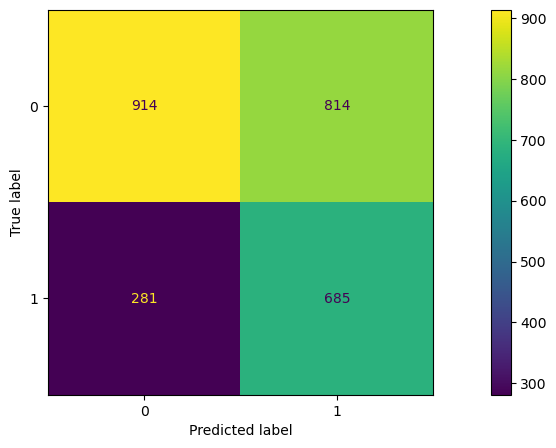

In [38]:
model2_KNN.fit(x_train,y_train)
y_pred_KNN=model2_KNN.predict(x_test)


cm = confusion_matrix(y_test, y_pred_KNN, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0,1])

print(classification_report(y_pred_KNN,y_test))
disp.plot()
plt.show()

# Summary and results

## Accuracy

| Model (optimizer)| Dataset 1 | Dataset 2 |
| --- | --- | --- |
| **CNN 1 (Adam)** | 0.90 | 0.82 |
| **CNN 1 (SGD)** | 0.85 | 0.77 |
| **CNN 2 (Adam)** | 0.87 | 0.79 |
| **CNN 2 (SGD)** | 0.85 | 0.77 |
| **NN 1 (Adam)** | 0.38 | 0.64 |
| **NN 1 (SGD)** | 0.78 | 0.71 |
| **NN 2 (Adam)** | 0.77 | 0.70 |
| **NN 2 (SGD)** | 0.77 | 0.73 |
| **KNN7** | 0.64 | 0.68 |
| **KNN10** | 0.68 | 0.59 |

## Loss

| Model (optimizer)| Dataset 1 | Dataset 2 |
| --- | --- | --- |
| **CNN 1 (Adam)** | 0.25 | 0.4 |
| **CNN 1 (SGD)** | 0.33 | 0.45 |
| **CNN 2 (Adam)** | 0.31 | 0.45 |
| **CNN 2 (SGD)** | 0.33 | 0.47 |
| **NN 1 (Adam)** | 0.69 | 0.69 |
| **NN 1 (SGD)** | 0.45 | 0.54 |
| **NN 2 (Adam)** | 0.47 | 0.56 |
| **NN 2 (SGD)** | 0.48 | 0.53 |

We can clearly see that Convolutional Neural Network model with two hidden layers performs the best with accuracy of 90% and loss of 0.25 on Dataset 1. It is also quite noticable that models trained on Dataset 1, the one without image augumentation, give better results. When it comes to optimizers, we could say that Adam gives better results for CNN, and SGD for NeuralNet models. Overall the CNN models outperformed the rest, which is quite obvious, but NN models also gave good results considering that they aren't realy suitable for image classification tasks. KNearestNeigbours (which is the simplest model used for image classification) results aren't the best but they could improve with some hyperparameter tuning. 